In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import gower
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from numpy.random import seed
from numpy.random import rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from dtreeviz.trees import dtreeviz
from sklearn import svm
import libsvm
from libsvm.svmutil import *

#### Accuracy

In [2]:
def accuracy(predict, label):
    cm = confusion_matrix(label, predict)
    return sum(np.diag(cm))/cm.sum()

## PCA and cleaning

In [3]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

Notice for both train and test dataset, I all have the missing value. Thus, for train dataset, we simply delete the columns with missing data since we have enought data and the missing is not alot. However, for the test data, to finish all the prediction in kaggle requirement, I replace the na by the most common variable in that column.

In [4]:
train_set.info()
print("\n")
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7471 entries, 0 to 7470
Data columns (total 22 columns):
id                        7471 non-null int64
Decision                  7471 non-null int64
Host_response_time        6613 non-null object
Host_is_superhost         7375 non-null object
Host_has_profile_pic      7375 non-null object
Host_identity_verified    7375 non-null object
Neighbourhood             7471 non-null int64
Property_type             7471 non-null object
Room_type                 7471 non-null object
Accommodates              7471 non-null int64
Bathrooms_text            7471 non-null object
Bedrooms                  6886 non-null float64
Beds                      7458 non-null float64
Essentials                7471 non-null int64
Cooking                   7471 non-null int64
Balcony                   7471 non-null int64
Parking                   7471 non-null int64
Price                     7471 non-null object
Number_of_reviews         7471 non-null int64
Review_

In [5]:
#after drop train dataset has 5866 observation in total
train_set_dropna=train_set.dropna()

In [6]:
for column in test_set:
    mode = test_set[column].mode()
    test_set[column] = test_set[column].fillna(mode[0])

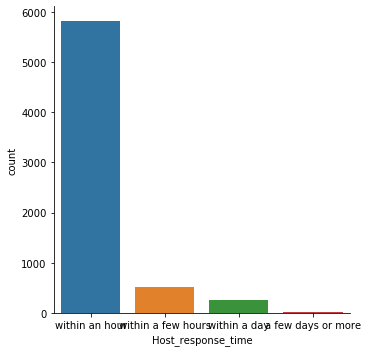

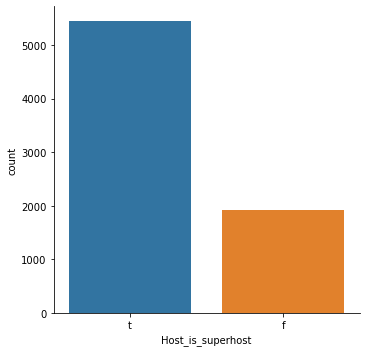

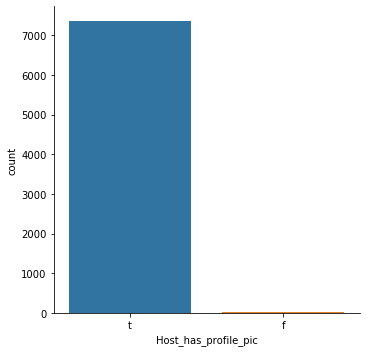

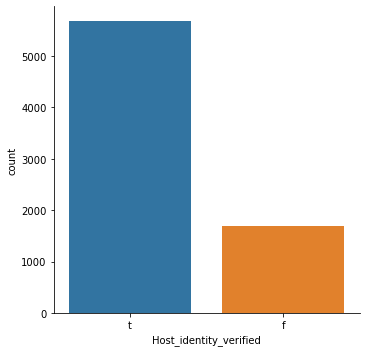

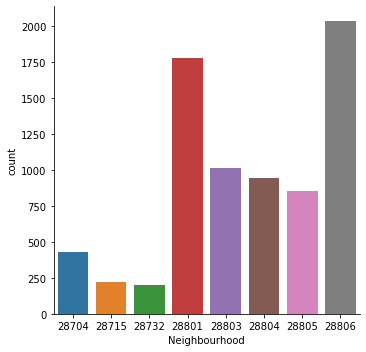

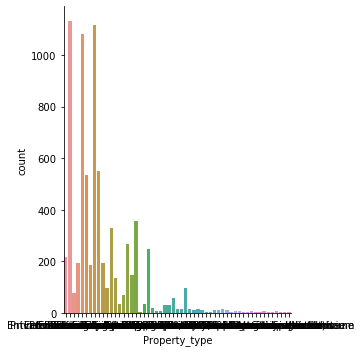

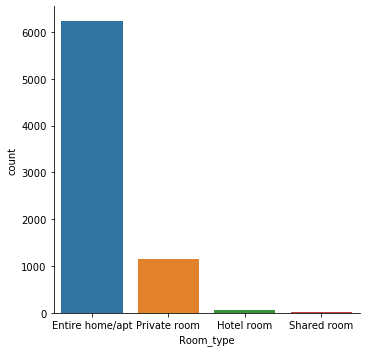

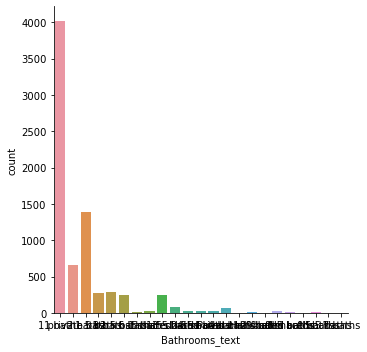

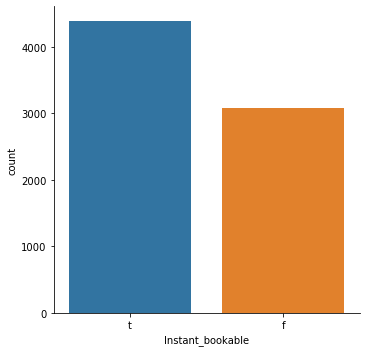

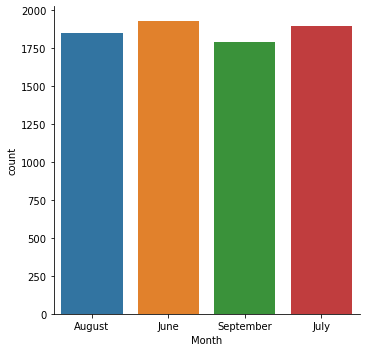

In [7]:
## no reason to treat id as an parameter to build the model
X_train = train_set_dropna.iloc[:,2:len(train_set.columns)]
y_train = train_set_dropna.iloc[:,1]
X_test = test_set.iloc[:,1:len(test_set.columns)]
##simple plot to explore the dataset on non-numeric data 
for column in ['Host_response_time','Host_is_superhost','Host_has_profile_pic','Host_identity_verified','Neighbourhood','Property_type','Room_type','Bathrooms_text','Instant_bookable','Month']:
    sns.catplot(x=column, kind="count", data=train_set)

In [8]:
## transfer T f data To 1 AND 0
X_train.Host_is_superhost=X_train.Host_is_superhost.map({'t':1,'f':0})
X_train.Host_has_profile_pic=X_train.Host_has_profile_pic.map({'t':1,'f':0})
X_train.Host_identity_verified=X_train.Host_identity_verified.map({'t':1,'f':0})
X_train.Instant_bookable=X_train.Instant_bookable.map({'t':1,'f':0})

X_test.Host_is_superhost=X_test.Host_is_superhost.map({'t':1,'f':0})
X_test.Host_has_profile_pic=X_test.Host_has_profile_pic.map({'t':1,'f':0})
X_test.Host_identity_verified=X_test.Host_identity_verified.map({'t':1,'f':0})
X_test.Instant_bookable=X_test.Instant_bookable.map({'t':1,'f':0})

In [9]:
## For the Price, split is by dollars sign and save the price as numerical
X_train.Price=X_train.Price.str.strip("$").str.replace(",","").astype('float')
X_test.Price=X_test.Price.str.strip("$").str.replace(",","").astype('float')

In [10]:
X_train=X_train.reset_index(drop=True)

In [11]:
## create dummy variable for categorical data and notice Neighbourhood is categorical instead of numerical.
## Notice when creating dummy variable, it is possible that train data has more category than test data. Thus we need to conbine them first
X_train.Neighbourhood=X_train.Neighbourhood.astype('str')
X_test.Neighbourhood=X_test.Neighbourhood.astype('str')

df=X_train.append(X_test,sort=False).reset_index(drop=True)
for column in ['Host_response_time','Neighbourhood','Property_type','Room_type','Bathrooms_text','Month']:
    encoder=OneHotEncoder(sparse= False)
    df_encoded=pd.DataFrame(encoder.fit_transform(df[[column]]))
    df_encoded.columns=encoder.get_feature_names([column])
    df.drop([column],axis=1,inplace=True)
    df=pd.concat([df,df_encoded],axis=1)

In [12]:
X_train=df[:5866]
X_test=df[5866:]

In [13]:
X_test=X_test.reset_index(drop=True)

In [14]:
## However, for the parameter that has same value in X_train, it is meaningless to include them in the model, thus, delete such variable from both train and test dataset
X_train_stand=(X_train-X_train.mean())/X_train.std()
X_test_stand=(X_test-X_train.mean())/X_train.std()

X_train_stand_clean=X_train_stand.drop(list(X_train.columns[X_train.std()==0]),axis=1)
X_test_stand_clean=X_test_stand.drop(list(X_train.columns[X_train.std()==0]),axis=1)

In the end, I have the train dataset with 5866 observations and 101 parameters. Notice even thought we have lots of variable, we also have relatively larger number of observations. Moreover, using PCA may let the interpretation to be harder since the parameters after PCA is much messy. Thus, I do not choose using PCA here.

## Method

#### Random Forest

In [15]:
# Initialize KFold object to be used throughout remaining code
kf = KFold(n_splits = 5)

In [16]:
## use cross validation for tuning parameters to compare different hyper-parameter, which the critertion in gini or entropy and the max depth from 3 to 37, the third of the total number of parameter
depths = range(3,50,2)

gini_acur=[]
entropy_acur=[]

for depth in depths:
    ##gini
    gini_forest=RandomForestClassifier(n_estimators=50,criterion='gini',max_depth=depth)
    gini_acur.append(cross_validate(gini_forest,X_train_stand_clean,y_train)['test_score'].mean())
    
    #entropy
    entropy_forest=RandomForestClassifier(n_estimators=50,criterion='entropy',max_depth=depth)
    entropy_acur.append(cross_validate(entropy_forest,X_train_stand_clean,y_train)['test_score'].mean())
    

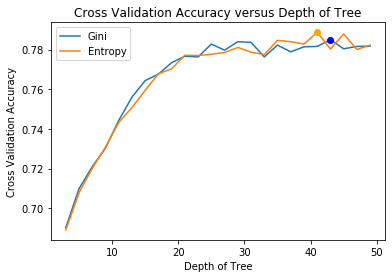

In [17]:
plt.plot(depths,gini_acur,label = "Gini")
plt.plot(depths,entropy_acur,label="Entropy")
plt.plot(depths[gini_acur.index(max(gini_acur))],gini_acur[gini_acur.index(max(gini_acur))],color='blue',marker = 'o')
plt.plot(depths[entropy_acur.index(max(entropy_acur))],entropy_acur[entropy_acur.index(max(entropy_acur))],color='orange',marker = 'o')
plt.legend()
plt.title("Cross Validation Accuracy versus Depth of Tree")
plt.xlabel("Depth of Tree")
plt.ylabel("Cross Validation Accuracy")
plt.show()

In [18]:
print("The highest CV acurracy get from gini forest is",max(gini_acur),"at depth", depths[gini_acur.index(max(gini_acur))])
print("The highest CV acurracy get from enthropy forest is",max(entropy_acur),"at depth", depths[entropy_acur.index(max(entropy_acur))])

The highest CV acurracy get from gini forest is 0.7850320455565383 at depth 43
The highest CV acurracy get from enthropy forest is 0.7887819493399908 at depth 41


Thus, from the cross validation, we best performance model from random forest is the Entropy forest with depth 49. However, for gini forest with depth 33, it has almost same accuracy but much less depths, which means it use much less parameter to achieve almost same result. Thus, I just Gini forest with depth 33 as my final forest model

In [19]:
## Build the model with whole train dataset and make the prediction
start = time.time()
final_forest=RandomForestClassifier(n_estimators=50,criterion='gini',max_depth=33)
final_forest.fit(X_train_stand_clean, y_train)
end=time.time()
print("The model build in", end-start, "s")

The model build in 0.445512056350708 s


In [86]:
y_train_predict = final_forest.predict(X_train_stand_clean)
start=time.time()
y_test_predict = final_forest.predict(X_test_stand_clean)
end=time.time()
print(end-start)
accuracy(y_train_predict,y_train)

0.039989471435546875


0.9998295260825094

In [21]:
pd.concat([test_set.id,pd.DataFrame(dict(Decision=y_test_predict))],axis=1).to_csv("Random_forest.csv",index=False)

The score from the kaggle before all the result can be observed is 0.325

In [22]:
#dtreeviz(final_forest.estimators_[1], X_train, y_train,
            #target_name="Airbnb Availability",
            #title="100th decision tree - Wine data")

#### Euclidean K-Nearest Neighbor

In [23]:
k_list = range(3,50,2)

uni_acur=[]
weight_acur=[]

for k in k_list:
    #uniform
    uni_knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors = k, weights = 'uniform', metric = 'euclidean')
    uni_acur.append(cross_validate(uni_knn,X_train_stand_clean,y_train)['test_score'].mean())
    
    #weight
    weight_knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors = k, weights = 'distance', metric = 'euclidean')
    weight_acur.append(cross_validate(weight_knn,X_train_stand_clean,y_train)['test_score'].mean())

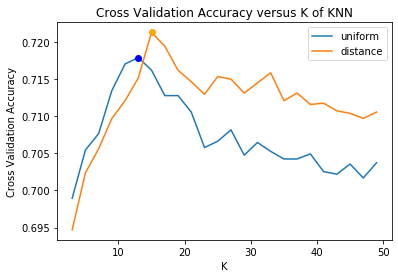

In [24]:
plt.plot(k_list,uni_acur,label = "uniform")
plt.plot(k_list,weight_acur,label="distance")
plt.plot(k_list[uni_acur.index(max(uni_acur))],uni_acur[uni_acur.index(max(uni_acur))],color='blue',marker = 'o')
plt.plot(k_list[weight_acur.index(max(weight_acur))],weight_acur[weight_acur.index(max(weight_acur))],color='orange',marker = 'o')
plt.legend()
plt.title("Cross Validation Accuracy versus K of KNN")
plt.xlabel("K")
plt.ylabel("Cross Validation Accuracy")
plt.show()

In [25]:
print("The highest CV acurracy get from uniform KNN is",max(uni_acur),"at k=", k_list[uni_acur.index(max(uni_acur))])
print("The highest CV acurracy get from Weight KNN is",max(weight_acur),"at k=", k_list[weight_acur.index(max(weight_acur))])

The highest CV acurracy get from uniform KNN is 0.7178678122608202 at k= 13
The highest CV acurracy get from Weight KNN is 0.7212765648441437 at k= 15


Thus, from the cross validation, we best performance model from Euclidean KNN is the Weight KNN with K 15.

In [26]:
## Build the model with whole train dataset and make the prediction
start = time.time()
final_knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance', metric = 'euclidean')
final_knn.fit(X_train_stand_clean, y_train)
end=time.time()
print("The model build in", end-start, "s")

The model build in 0.004850625991821289 s


In [84]:
y_train_predict = final_knn.predict(X_train_stand_clean)
start=time.time()
y_test_predict = final_forest.predict(X_test_stand_clean)
end=time.time()
print(end-start)
accuracy(y_train_predict,y_train)

0.035572052001953125


1.0

In [28]:
pd.concat([test_set.id,pd.DataFrame(dict(Decision=y_test_predict))],axis=1).to_csv("KNN.csv",index=False)

#### SVM

In [29]:
y_train_np=np.array(y_train)
X_train_np=np.array(X_train_stand_clean)
X_test_np=np.array(X_test_stand_clean)

In [52]:
##linear
##Notice for libsvm we can not use cv from sklearn. Thus,write own cv here
C_range = [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**-0]
linear_acur = []
train_acur_list=[]
param = svm_parameter('-s 0 -t 0')

for c in C_range:
    param.C=c
    test_acurracy=0
    train_acur=0
    for train_index,test_index in kf.split(X_train_np):
        X_train_fold, X_test_fold = X_train_np[train_index,:], X_train_np[test_index,:]
        y_train_fold, y_test_fold = y_train_np[train_index], y_train_np[test_index]
        prob=svm_problem(y_train_fold,X_train_fold)
        model = svm_train(prob, param)
        p_label, p_acc, p_val = svm_predict(y_test_fold, X_test_fold, model, options = '-q')
        
        test_acurracy+=(float(p_acc[0]/5))
        p_label, p_acc, p_val = svm_predict(y_train_fold, X_train_fold, model, options = '-q')
        train_acur+=(float(p_acc[0]/5))
    
    linear_acur.append(test_acurracy)
    train_acur_list.append(train_acur)    


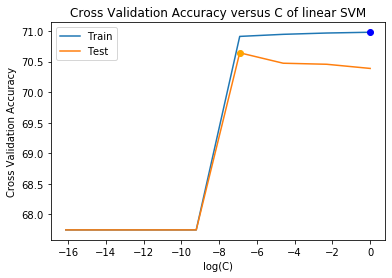

In [87]:
plt.plot(np.log(C_range),train_acur_list,label = "Train")
plt.plot(np.log(C_range),linear_acur,label = "Test")
plt.plot(list(np.log(C_range))[train_acur_list.index(max(train_acur_list))],train_acur_list[train_acur_list.index(max(train_acur_list))],color='blue',marker = 'o')
plt.plot(list(np.log(C_range))[linear_acur.index(max(linear_acur))],linear_acur[linear_acur.index(max(linear_acur))],color='orange',marker = 'o')
plt.legend()
plt.title("Cross Validation Accuracy versus C of linear SVM")
plt.xlabel("log(C)")
plt.ylabel("Cross Validation Accuracy")
plt.show()

In [58]:
print("The highest CV acurracy get from linear SVM is",max(linear_acur),"at C=", C_range[linear_acur.index(max(linear_acur))])

The highest CV acurracy get from linear SVM is 70.64462908339397 at C= 0.001


In [59]:
## quadratic
test_acurracy=0
train_acur=0
for train_index,test_index in kf.split(X_train_np):
    X_train_fold, X_test_fold = X_train_np[train_index,:], X_train_np[test_index,:]
    y_train_fold, y_test_fold = y_train_np[train_index], y_train_np[test_index]
    param = svm_parameter('-s 0 -t 1 -d 3')
    prob=svm_problem(y_train_fold,X_train_fold)
    model = svm_train(prob, param)
    p_label, p_acc, p_val = svm_predict(y_test_fold, X_test_fold, model, options = '-q')
    test_acurracy+=(float(p_acc[0]/5))
    p_label, p_acc, p_val = svm_predict(y_train_fold, X_train_fold, model, options = '-q')
    train_acur+=(float(p_acc[0]/5))

In [61]:
print("The CV acurracy for quadratic SVM is", test_acurracy)

The CV acurracy for quadratic SVM is 71.9574149191563


In [62]:
#radical kernel
sigmasq=[1,2,4,8,16,32,128]
train_accuracy=[]
test_accuracy=[]
for sigma in sigmasq:
    param = svm_parameter('-s 0 -t 2 -g '+str(1/sigma))
    test_acur=0
    train_acur=0
    for train_index,test_index in kf.split(X_train_np):
        X_train_fold, X_test_fold = X_train_np[train_index,:], X_train_np[test_index,:]
        y_train_fold, y_test_fold = y_train_np[train_index], y_train_np[test_index]
        prob=svm_problem(y_train_fold,X_train_fold)
        model = svm_train(prob, param)
        p_label, p_acc, p_val = svm_predict(y_test_fold, X_test_fold, model, options = '-q')
        
        test_acur+=(float(p_acc[0]/5))
        p_label, p_acc, p_val = svm_predict(y_train_fold, X_train_fold, model, options = '-q')
        train_acur+=(float(p_acc[0]/5))
        
    test_accuracy.append(test_acur)
    train_accuracy.append(train_acur)

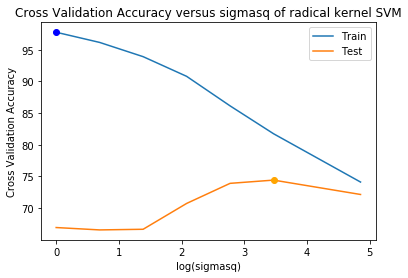

In [88]:
plt.plot(np.log(sigmasq),train_accuracy,label = "Train")
plt.plot(np.log(sigmasq),test_accuracy,label = "Test")
plt.plot(list(np.log(sigmasq))[train_accuracy.index(max(train_accuracy))],train_accuracy[train_accuracy.index(max(train_accuracy))],color='blue',marker = 'o')
plt.plot(list(np.log(sigmasq))[test_accuracy.index(max(test_accuracy))],test_accuracy[test_accuracy.index(max(test_accuracy))],color='orange',marker = 'o')
plt.legend()
plt.title("Cross Validation Accuracy versus sigmasq of radical kernel SVM")
plt.xlabel("log(sigmasq)")
plt.ylabel("Cross Validation Accuracy")
plt.show()

In [64]:
print("The highest CV acurracy get from radical SVM is",max(test_accuracy),"at sigmasq=", sigmasq[test_accuracy.index(max(test_accuracy))])

The highest CV acurracy get from radical SVM is 74.42921439370504 at sigmasq= 32


In [81]:
## Final svm model
start=time.time()
param = svm_parameter('-s 0 -t 2 -g '+str(1/32))
prob=svm_problem(y_train_np,X_train_np)
Final_svm=svm_train(prob, param)
end=time.time()
print("The model build in", end-start, "s")
p_label, p_acc, p_val = svm_predict([], X_test_np, Final_svm, options = '-q')

The model build in 7.325839281082153 s


In [82]:
pd.DataFrame(dict(Decision=map(int,p_label)))

,Decision
0,0
1,1
2,1
3,1
4,1
...,...
2435,1
2436,1
2437,1
2438,1


In [83]:
pd.concat([test_set.id,pd.DataFrame(dict(Decision=map(int,p_label)))],axis=1).to_csv("svm.csv",index=False)

## Interpretation

In [89]:
pd.DataFrame({'Variable':X_train_stand_clean.columns,
              'Importance':final_forest.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
10,Price,0.138561
11,Number_of_reviews,0.129382
12,Review_scores_rating,0.094241
3,Accommodates,0.047325
7,Cooking,0.042827
...,...,...
95,Bathrooms_text_7 baths,0.000062
29,Property_type_Casa particular,0.000060
60,Property_type_Private room in hostel,0.000026
28,Property_type_Campsite,0.000019
